In [1]:
## ALL IMPORTS FOR A NEW NOTEBOOK
__SEED = 0
__N_FOLDS = 5
__NROWS = None

import os, sys, random, math
import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use('ggplot')

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import ml_utils as mutils
import time, datetime, pickle


# fold1 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED)
# fold2 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED+3)
# fold3 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED+5)
font = {'size'   : 14}
matplotlib.rc('font', **font)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train = pd.read_csv("./train.csv", index_col="id")
test = pd.read_csv("./test.csv", index_col="id")

# train["ord_6"] = train["ord_5"].str[1]
# train["ord_5"] = train["ord_5"].str[0]
# train["bin_3"] = train["bin_3"].map({"F":0, "T":1})
# train["bin_4"] = train["bin_4"].map({"N":0, "Y":1})

# test["ord_6"] = test["ord_5"].str[1]
# test["ord_5"] = test["ord_5"].str[0]
# test["bin_3"] = test["bin_3"].map({"F":0, "T":1})
# test["bin_4"] = test["bin_4"].map({"N":0, "Y":1})

In [3]:
stats,_,_ = mutils.summarize_categorical(train, test, exclude_feat=["target"], target_for_cramerV="target")
stats

,Feature,Target Cramer's V,Unique values (Train),Unique values (Test),Train only value counts,Test only value counts,Missing (Train),Missing (Test),Value with the highest counts (Train),DataType
0,bin_0,0.060,2,2,0(0.0),0(0.0),17894(2.982),17894(2.982),0.0(88.063),float64
1,bin_1,0.018,2,2,0(0.0),0(0.0),18003(3.0),18003(3.0),0.0(79.003),float64
2,bin_2,0.066,2,2,0(0.0),0(0.0),17930(2.988),17930(2.988),0.0(69.974),float64
3,bin_3,0.001,2,2,0(0.0),0(0.0),18014(3.002),18014(3.002),F(61.035),object
4,bin_4,0.019,2,2,0(0.0),0(0.0),18047(3.008),18047(3.008),N(52.057),object
5,nom_0,0.016,3,3,0(0.0),0(0.0),18252(3.042),18252(3.042),Red(53.881),object
6,nom_1,0.071,6,6,0(0.0),0(0.0),18156(3.026),18156(3.026),Triangle(27.365),object
7,nom_2,0.046,6,6,0(0.0),0(0.0),18035(3.006),18035(3.006),Hamster(27.483),object
8,nom_3,0.060,6,6,0(0.0),0(0.0),18121(3.02),18121(3.02),India(27.478),object
9,nom_4,0.042,4,4,0(0.0),0(0.0),18035(3.006),18035(3.006),Theremin(51.437),object


In [4]:
train = train.drop(["bin_3"], axis=1)
test = test.drop(["bin_3"], axis=1)

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.le_={}
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        
        df = X.copy()
        for i, col in enumerate(self.columns):
            le = pp.LabelEncoder()
            self.le_[col] = le
            df[col] = le.fit_transform(df[col].astype(str))
        return df


class CustomMostFrequentImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.mode = None
    def fit(self, X, y=None):
        self.mode = X[self.columns].mode().values[0]
        return self
    def transform(self, X, y=None):
        df = X.copy()
        for i, col in enumerate(self.columns):
            df[col].fillna(self.mode[i],inplace=True)
        return df

class CustomMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.median = None
    def fit(self, X, y=None):
        self.median = X[self.columns].median().values
        return self
    def transform(self, X, y=None):
        df = X.copy()
        for i, col in enumerate(self.columns):
            df[col].fillna(self.median[i],inplace=True)
        return df

class CustomNewCategoryImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = X.copy()
        for i, col in enumerate(self.columns):
            df[col].fillna("NoData",inplace=True)
            df[col] = df[col].astype(str)
        return df

class CrossValTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, cv):
        self.transformer = transformer
        self.cv = cv
    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self
    def transform(self, X, y=None):
        df = X.copy()
        df = self.transformer.transform(X, y)
        return df
    def get_oof_transform(self, X, y):
        oof = pd.DataFrame(index=X.index, columns=X.columns)
        for train_idx, valid_idx in self.cv.split(X,y):
            train_X = X.loc[train_idx]
            train_y = y.loc[train_idx]
            valid_X = X.loc[valid_idx]
            valid_y = y.loc[valid_idx]
            
            self.transformer.fit(train_X, train_y)
            oof_txf = self.transformer.transform(valid_X)
            
            oof.loc[valid_idx] = oof_txf
        return oof

In [6]:
bf = [f for f in train.columns if f.startswith("bin")]
nf = [f for f in train.columns if f.startswith("nom")]
of = [f for f in train.columns if f.startswith("ord")]
tf = ["day","month"]

In [7]:
imputer = CustomNewCategoryImputer(bf+nf+of+tf)
train = imputer.fit_transform(train)
test = imputer.transform(test)

In [8]:
trainX = train[bf+nf+of+tf]
trainY = train["target"]
testX = test

all_data = pd.concat([trainX,testX], sort=True)

In [9]:
cle = CustomLabelEncoder(bf+nf+of+tf)

In [10]:
all_data = cle.fit_transform(all_data)

In [11]:
trainX_txf = all_data[:len(trainX)]
testX_txf = all_data[len(trainX):]

In [12]:
uniques = {}
for c in all_data.columns:
    uniques[c] = len(np.unique(all_data[c]))

In [145]:
embedding_sizes = [(n_cat, min(50, (n_cat+1)//2)) for _, n_cat in uniques.items()]

In [146]:
from torch.utils.data import Dataset, DataLoader
class CustomDataSet(Dataset):
    def __init__(self, X, Y=None):
        self.X = X.copy().values.astype(np.int64)
        if Y is not None:
            self.y = Y.values.astype(np.float32)
        else:
            self.y = None
        self.length = X.shape[0]
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

In [147]:
train_x,valid_x,train_y,valid_y = ms.train_test_split(trainX_txf, trainY, test_size=0.15, random_state=__SEED)

In [172]:
trainData = CustomDataSet(train_x, train_y)
validData = CustomDataSet(valid_x, valid_y)
testData = CustomDataSet(testX_txf)


batch_size = 512
trainLoader = DataLoader(trainData, batch_size=batch_size, shuffle=True)
validLoader = DataLoader(validData, batch_size=batch_size, shuffle=False)
testLoader = DataLoader(testData, batch_size=batch_size, shuffle=False)

In [246]:
class Model(nn.Module):
    def __init__(self, embedding_sizes):
        super(Model, self).__init__()
        
        self.embeddings = nn.ModuleList([nn.Embedding(cat,size) for cat, size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings)
        
        self.n_emb= n_emb
        
        self.lin1 = nn.Linear(self.n_emb, 512)
        self.lin2 = nn.Linear(512,256)
        self.lin3 = nn.Linear(256,2)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(256)
        self.emb_drop = nn.Dropout(0.5)
        self.oth_drop = nn.Dropout(0.5)
    
    def forward(self, x_cat):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
        x = torch.cat(x,dim=1)
        x = self.emb_drop(x)
        x = self.bn2(self.oth_drop(F.relu(self.lin1(x))))
        x = self.bn3(self.oth_drop(F.relu(self.lin2(x))))
        return self.lin3(x)

In [247]:
def train_epoch(model, iterator, optimizer, criterion, device="cpu"):
    el,eauc = 0,0
    model.train()
    for x,y in iterator:
        optimizer.zero_grad()
        x,y = x.to(device),y.to(device)
        output = model(x)
        loss = criterion(output, y.long())
        loss.backward()
        optimizer.step()
        
        eauc+=metrics.roc_auc_score(y.cpu().numpy(), output.cpu().detach().numpy()[:,1])
        el+=loss.item()
    
    return el/len(iterator), eauc/len(iterator)

In [263]:
def evaluate(model, iterator, criterion, device="cpu"):
    el,eauc = 0,0
    model.eval()
    
    with torch.no_grad():
        for x,y in iterator:
            x,y = x.to(device),y.to(device)
            output = model(x)
            loss = criterion(output, y.long())
            
            eauc+=metrics.roc_auc_score(y.cpu().numpy(), output.cpu().detach().numpy()[:,1])
            el+=loss.item()
    
    return el/len(iterator), eauc/len(iterator)

In [264]:
model = Model(embedding_sizes)
model = model.to(device)
optimizer = mutils.RAdam(model.parameters(),lr=0.005, weight_decay=0.00001)

In [265]:
print("TRAINING ON {}".format(device))
N_EPOCHS = 5
criterion= nn.CrossEntropyLoss()
history = pd.DataFrame()

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_auc = train_epoch(model, trainLoader, optimizer, criterion, device=device)
    valid_loss, valid_auc = evaluate(model, validLoader, criterion ,device=device)
    mutils.print_epoch_stat(epoch, time.time()-start_time,history=history, train_loss=train_loss, train_accuracy=train_auc, valid_loss=valid_loss, valid_accuracy=valid_auc)

TRAINING ON cuda


EPOCH 1 Completed, Time Taken: 0:00:16.422053
	Train Loss 	0.480143842
	Train Accuracy 	61.0749955%
	Valid Loss 	0.421284097
	Valid Accuracy 	75.0372021%


EPOCH 2 Completed, Time Taken: 0:00:15.940378
	Train Loss 	0.429703501
	Train Accuracy 	71.4565637%
	Valid Loss 	0.407245878
	Valid Accuracy 	77.7969851%


EPOCH 3 Completed, Time Taken: 0:00:16.170225
	Train Loss 	0.41961382
	Train Accuracy 	74.8285588%
	Valid Loss 	0.402381891
	Valid Accuracy 	78.2389495%


EPOCH 4 Completed, Time Taken: 0:00:16.053677
	Train Loss 	0.414090679
	Train Accuracy 	76.0718493%
	Valid Loss 	0.398177542
	Valid Accuracy 	78.5352321%


EPOCH 5 Completed, Time Taken: 0:00:16.591213
	Train Loss 	0.411421076
	Train Accuracy 	76.5618253%
	Valid Loss 	0.400034723
	Valid Accuracy 	78.4387064%


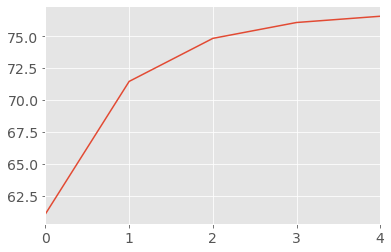

In [266]:
history['train_accuracy'].plot()

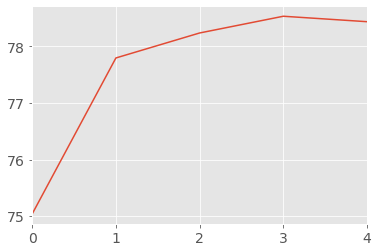

In [267]:
history['valid_accuracy'].plot()

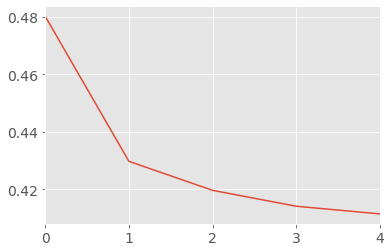

In [268]:
history['train_loss'].plot()

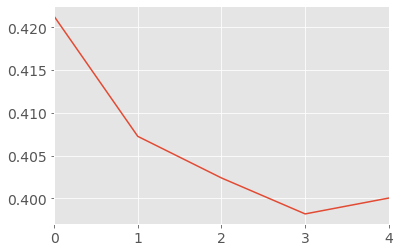

In [269]:
history['valid_loss'].plot()

In [270]:
preds = []
model.eval()
with torch.no_grad():
    for x in testLoader:
        x = x.to(device)
        out = model(x)
        probs = torch.softmax(out, dim=1)
        preds.append(probs.cpu().detach().numpy()[:,1])

In [271]:
preds = [item for sublist in preds for item in sublist]    

In [272]:
preds

[0.17338069,
 0.28008416,
 0.17126541,
 0.15905161,
 0.19399889,
 0.12941161,
 0.49703795,
 0.18394029,
 0.21112673,
 0.31145152,
 0.14707646,
 0.11384462,
 0.4505375,
 0.015252007,
 0.07118838,
 0.13115211,
 0.25471988,
 0.118446864,
 0.27089915,
 0.06697146,
 0.16652338,
 0.28413764,
 0.13454393,
 0.10809766,
 0.15712173,
 0.2986565,
 0.030764483,
 0.30612946,
 0.14769249,
 0.19991116,
 0.32006156,
 0.05806946,
 0.22729206,
 0.36648938,
 0.2573342,
 0.412183,
 0.059361037,
 0.4085226,
 0.2527762,
 0.02454522,
 0.3429647,
 0.080329254,
 0.10454114,
 0.1757253,
 0.3740575,
 0.575718,
 0.07427552,
 0.08185236,
 0.16573486,
 0.2724496,
 0.07337362,
 0.1165288,
 0.029729556,
 0.2653028,
 0.21463193,
 0.27640057,
 0.024092682,
 0.21571447,
 0.24612232,
 0.14038439,
 0.15417717,
 0.2875982,
 0.057899904,
 0.18970193,
 0.12894614,
 0.23706105,
 0.16822349,
 0.1469306,
 0.09681677,
 0.05032947,
 0.554138,
 0.10280932,
 0.17260857,
 0.057265263,
 0.08671484,
 0.21218847,
 0.09042584,
 0.035139

In [273]:
subdf = pd.DataFrame()

In [274]:
subdf["id"] = test.index

In [275]:
subdf["target"] = preds

In [276]:
subdf.to_csv("CONTR_VANILLA_ENTITY_EMB.csv", index=False)